## Importing packages

In [191]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Rescaling,BatchNormalization
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import Callback
import matplotlib.pyplot as plt

## Importing data

In [192]:
df = pd.read_csv('age_gender.csv')

## EDA and visualization

In [193]:
df.shape

(23705, 5)

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [195]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


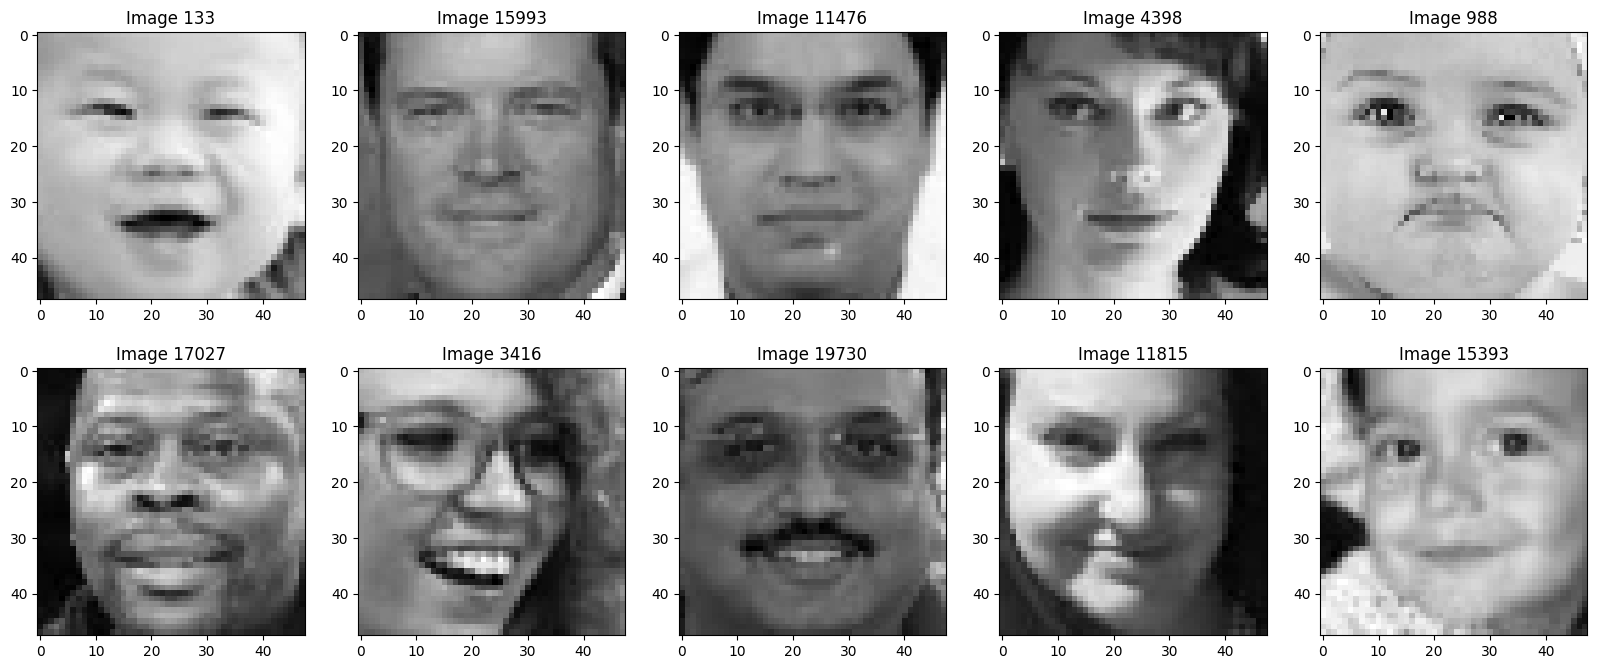

In [196]:
image_size = (48, 48)
pixel_data = df['pixels'].str.split(' ', expand=True).astype(int)
images = pixel_data.values.reshape(-1, *image_size)
num_images = len(df)
random_indices = np.random.choice(num_images, 10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img_index = random_indices[i]
    ax.imshow(images[img_index], cmap='gray')
    ax.set_title(f'Image {img_index}')

plt.show()

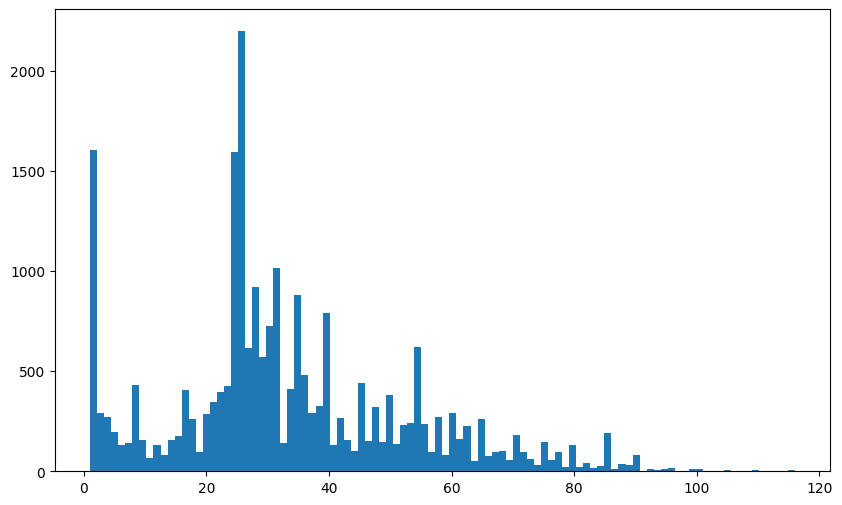

In [197]:
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=100)
plt.show()

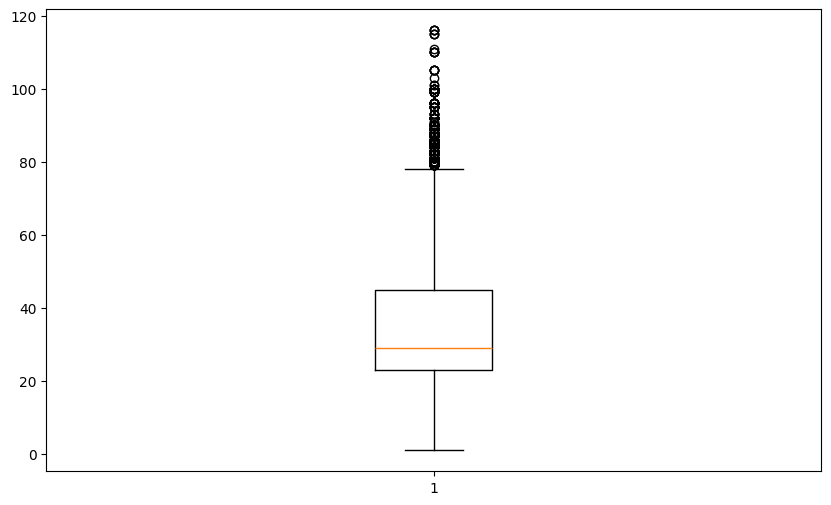

In [198]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['age']);

## Wrangling

In [199]:
df.drop(columns=['img_name', 'gender','ethnicity'], inplace=True)

In [200]:
# df = df[df['age']<=70]

In [201]:
df.shape

(23705, 2)

## Data spliting

In [202]:
def image_handling(df):
    pixel_data = df['pixels'].str.split(' ', expand=True).astype(int)
    image_size = (48, 48)
    num_images = len(df)

    all_images = np.zeros((num_images, *image_size), dtype=float)

    for i in range(num_images):
        all_images[i] = pixel_data.iloc[i].values.reshape(image_size)
    
    return all_images

In [203]:
scal = StandardScaler()
df ['age'] = scal.fit_transform(df[['age']])

In [204]:
x = image_handling(df)
y = df[[ 'age']]

In [205]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

## Model

In [236]:
input_shape = (48, 48, 1)

model = Sequential([
    
    Input(shape=input_shape),

    Rescaling(1./255),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.7),
    Flatten(),

    Dense(512, activation='relu'),
    Dense(1, name='age_output')
])


model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_22 (Rescaling)    (None, 48, 48, 1)         0         
                                                                 
 conv2d_65 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 12, 12, 128)     

In [237]:
model.compile(loss="mean_squared_error",
              optimizer=Adam(learning_rate=0.001),
              metrics=[MeanAbsoluteError()])

In [242]:
history = model.fit(x_train, 
                    y_train,
                    epochs=10, 
                    batch_size=64, 
                    validation_data=(x_val, y_val))

Epoch 1/10
260/260 [==============================] - 3s 9ms/step - loss: 0.0739 - mean_absolute_error: 0.2055 - val_loss: 0.1943 - val_mean_absolute_error: 0.3148
Epoch 2/10
260/260 [==============================] - 2s 8ms/step - loss: 0.0738 - mean_absolute_error: 0.2058 - val_loss: 0.1944 - val_mean_absolute_error: 0.3159
Epoch 3/10
260/260 [==============================] - 2s 8ms/step - loss: 0.0709 - mean_absolute_error: 0.2017 - val_loss: 0.1875 - val_mean_absolute_error: 0.3090
Epoch 4/10
260/260 [==============================] - 2s 8ms/step - loss: 0.0720 - mean_absolute_error: 0.2026 - val_loss: 0.1879 - val_mean_absolute_error: 0.3104
Epoch 5/10
260/260 [==============================] - 2s 8ms/step - loss: 0.0724 - mean_absolute_error: 0.2035 - val_loss: 0.1946 - val_mean_absolute_error: 0.3127
Epoch 6/10
260/260 [==============================] - 2s 8ms/step - loss: 0.0701 - mean_absolute_error: 0.2012 - val_loss: 0.2017 - val_mean_absolute_error: 0.3213
Epoch 7/10
260/2

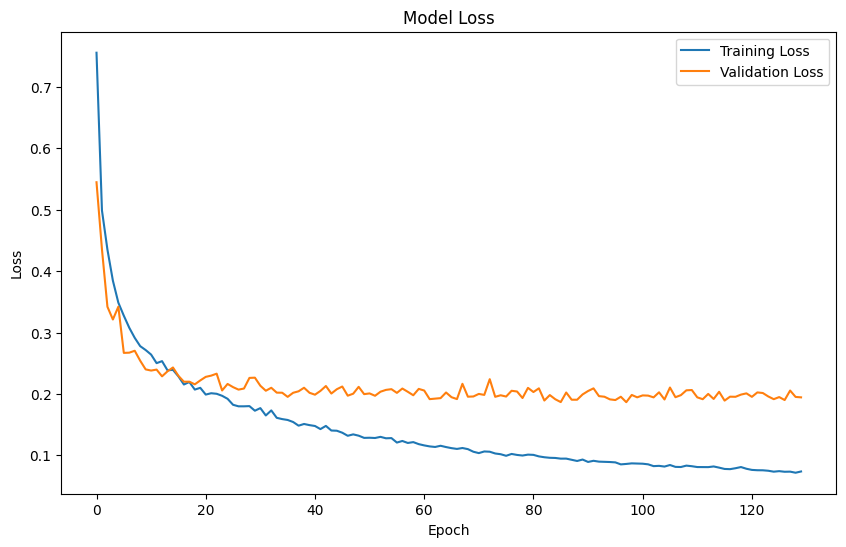

In [239]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [243]:
predictions = model.predict(x_test)

112/112 [==============================] - 0s 3ms/step


In [244]:
r2 = r2_score(y_test['age'], predictions)
print(f"R2 Score: {r2}")

R2 Score: 0.7929047005155649
